[]
[]
[[0, 10], [90, 100]]
[[20, 70, 10]]


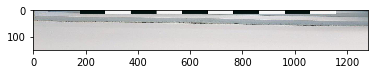

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyzbar.pyzbar as pyzbar
import copy




# -----------------       classify        ----------------


def classify(data, position):
    result = []
    for i in data:
        if i == []: break
        info = i.split('\\n')
        t = info[0].split('t:')[1]
        w = None if info[1].split('w:')[1] == '0' else int(info[1].split('w:')[1])
        if 'apoio' in t:
            result.append(classify_apoios(t, position))
        else:
            result.append(classify_cargas(t, w, position))
    return result
        
def classify_apoios(t, position):
    return [t, None, position] if t == 'apoio1' else [t, None, position]
    
def classify_cargas(t, w, position):
    return [t, w, position]





# -------------        detect    --------------------

def detect_viga_colors(img, xi, xf, yi, yf):
    yi+=2
    h, w = img.shape[:2]
    plt.imshow(img[yi:, :, ::-1])
    i = 0
    distance = 0 #irá armazenar a distância padrão
    ranges = [] #irá armazenar o início e fim de cada cor
    def_distance = [] #receberá as duas primeiras cores
    start = False #se tornará True quando for encontrada a primeira cor preta
    while i < xf-2 and len(def_distance) < 2: #ao encontrar as duas primeiras cores branco e preto é possível saber 
                                              #a distância em x delas
        if img[yi][i + 1][0] < 50 and img[yi][i + 1][1] < 50 and img[yi][i + 1][2] < 50 and not start:
            start = True
            def_distance.append(i+1)
        else:
            color = [abs(int(img[yi][i][0])), abs(int(img[yi][i][1])),
                     abs(int(img[yi][i][2]))]
            dif0 = abs(abs(int(img[yi][i][0])) - abs(int(img[yi][i + 1][0])))
            dif1 = abs(abs(int(img[yi][i][1])) - abs(int(img[yi][i + 1][1])))
            dif2 = abs(abs(int(img[yi][i][2])) - abs(int(img[yi][i + 1][2])))
            if ((dif0 >= 100 and dif1 >= 100) or (dif0 >= 100 and dif2 >= 100) or (dif1 >= 100 and dif2 >= 100)):
                def_distance.append(i+1)
                i+=5
        i += 1
    distance = def_distance[1]-def_distance[0]
    ranges = copy.copy(def_distance)
    for i in range(0, 10): #pegará as outras 8 cores (vai até 9 pq tem que pegar o fim da última cor)
        ranges.append(ranges[i+1]+distance)

    return ranges

def detect_qr_codes(qrcode, ranges):
    cut = {}
    data = []
    h, w = qrcode.shape[:2]
    position = 0
    for r in range(0, len(ranges) - 1):
        qr = copy.copy(qrcode)
        for i in range(0, w):
            if (i < ranges[position] or i > ranges[position + 1]):
                for j in range(0, h):
                    qr[j][i] = 0, 0, 0
        decodedObjects = pyzbar.decode(qr)
        if decodedObjects == []:
            data = []
        else:
            for code in decodedObjects:
                text = str(code[0])[2:2] + str(code[0])[2:]
                data.append(str(text)[:-1])
        cut[ranges[position]] = data
        data = []
        position += 1

    return cut

def detect_viga(img):
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 50)
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
    #cv2.line(img, (0, y1), (w, y2), (255, 255, 0), 3)
    #cv2.line(img, (x1, y1 + 25), (x2, y2 + 25), (0, 255, 0), 3)
    #cv2.line(img, (180, y1), (180, y1 + 25), (0, 255, 0), 3)
    #cv2.line(img, (h - 2, y1), (h - 2, y1 + 25), (0, 255, 0), 3)
    # demarcação da viga
    xi = 0
    xf = w
    yi = y1
    yf = y2
    #plt.imshow(img[y1:, :, ::-1])
    return [xi, xf, yi, yf]



def interpret(all_qr_codes):
    apoio1 = [] #cada apoio terá posição inicial, final
    apoio2 = []
    triangular = [] #cada triangulo: (pos_i(x, y), pos_f(x, y), peso)
    distribuida = [] 
    pontual = [] #cada pontual: (pos_i(x, y), pos_f(x, y), peso)
    i = 0
    begin = []
    end = []
    peso = 0
    finish_triangulo = False
    finish_distribuida = False
    while i < len(all_qr_codes):
        if len(all_qr_codes[i]) > 0:
            if 'triang' in all_qr_codes[i][0][0]:
                finish_triangulo = not finish_triangulo
                peso = all_qr_codes[i][0][1]
                if len(all_qr_codes[i]) == 1:
                    begin = [i*10, 0]
                else:
                    y = 0
                    if all_qr_codes[i][0][1] == 10:
                        y = 40
                    elif all_qr_codes[i][0][1] == 6:
                        y = 30
                    else:
                        y = 20
                    end = [(i+1)*10, y]
                if not finish_triangulo: 
                    triangular.append([begin, end, peso]) #triangular = (pos_i(x, y), pos_f(x, y), peso)
                    
            elif 'pontual' in all_qr_codes[i][0][0]:
                altura = all_qr_codes[i][0][1]*10
                peso = all_qr_codes[i][0][1]
                pontual.append([[i*10, altura], [(i+1)*10, altura], peso]) #pontual = (pos_i(x, y), pos_f(x, y), peso)
                                                                    #os y são iguais por ser no máximo uma coluna
            
            elif 'apoio 2' in all_qr_codes[i][0][0]: #apoio = (xi, xf)
                pos = [i*10, (i+1)*10]
                apoio2.append(pos)
                
            elif 'apoio 1' in all_qr_codes[i][0][0]: #apoio = (xi, xf)
                pos = [i*10, (i+1)*10]
                apoio1.append(pos)
            elif 'distr' in all_qr_codes[i][0][0]:
                peso = all_qr_codes[i][0][1]
                if not finish_distribuida:
                    begin = i*10
                    finish_distribuida = not finish_distribuida
                else:
                    end = (i+1)*10
                    distribuida.append([begin, end, peso])
                
        i+=1
        
    print(triangular)
    print(pontual)
    print(apoio2)
    print(distribuida)
                


            

# ---------- main --------

image = cv2.imread('img/distribuida_10.png')
h, w = image.shape[:2]

pos_viga = detect_viga(image)
#plt.imshow(image)


ranges = detect_viga_colors(image, pos_viga[0], pos_viga[1], pos_viga[2], pos_viga[3])

#plt.imshow(image)

qr_data = detect_qr_codes(image, ranges)

infos = []
for t in qr_data:
    infos.append(classify(qr_data[t], t))
    
pesos_apoios = interpret(infos)
#print(infos)
    

